In [ ]:
# clean data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator, Rbf, BSpline, make_interp_spline
from numpy.polynomial.polynomial import Polynomial
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF as GPR_RBF

def clean_and_interpolate(column, start_idx, end_idx, num_extra_points, prev_points, next_points, method='pchip'):
    """
    Cleans and interpolates the given column based on the specified indices and number of extra points.

    Parameters:
    column (pd.Series): The input column to clean and interpolate.
    start_idx (int): The starting index of the rows to replace or add data.
    end_idx (int): The ending index of the rows to replace or add data.
    num_extra_points (int): The number of extra data points to add.
    prev_points (int): The number of previous data points to consider for interpolation.
    next_points (int): The number of next data points to consider for interpolation.
    method (str): The interpolation method to use ('pchip', 'rbf', 'bspline', 'polynomial', 'gaussian_process').

    Returns:
    pd.Series: The cleaned and interpolated column.
    """
    # Ensure the input is a Pandas Series
    if not isinstance(column, pd.Series):
        column = pd.Series(column)

    # Ensure indices are within bounds
    start_idx = max(start_idx, 0)
    end_idx = min(end_idx, len(column) - 1)

    # if start_idx - end_idx <= 0:
    #     return column

    # Get the data points for interpolation
    interpolation_indices = list(range(start_idx - prev_points, start_idx)) + \
                            list(range(end_idx + 1, end_idx + 1 + next_points))
    interpolation_indices = [i for i in interpolation_indices if i >= 0 and i < len(column)]
    interpolation_values = column.iloc[interpolation_indices].values

    extra_indices = list(range(start_idx, end_idx + 1 + num_extra_points))

    interpolation_indices_ = list(range(start_idx - prev_points, start_idx)) + \
                             list(range(end_idx + 1 + num_extra_points, end_idx + num_extra_points + next_points + 1))

    # Perform interpolation based on the chosen method
    if method == 'pchip':
        interpolator = PchipInterpolator(interpolation_indices_, interpolation_values)
    elif method == 'rbf':
        interpolator = Rbf(interpolation_indices_, interpolation_values, function='multiquadric')
    elif method == 'bspline':
        t, c, k = make_interp_spline(interpolation_indices_, interpolation_values, k=3).tck
        interpolator = BSpline(t, c, k)
    elif method == 'polynomial':
        coefs = Polynomial.fit(interpolation_indices_, interpolation_values, deg=min(105, len(interpolation_indices_) - 1)).convert().coef
        interpolator = Polynomial(coefs)
    elif method == 'gaussian_process':
        kernel = GPR_RBF()
        gp = GaussianProcessRegressor(kernel=kernel)
        gp.fit(np.array(interpolation_indices_).reshape(-1, 1), interpolation_values)
        interpolator = lambda x: gp.predict(np.array(x).reshape(-1, 1))
    else:
        raise ValueError("Invalid interpolation method. Choose from 'pchip', 'rbf', 'bspline', 'polynomial', 'gaussian_process'.")

    # Interpolate values
    interpolated_values = interpolator(np.array(extra_indices))

    # Create a new series to accommodate the new data
    new_series = pd.Series(index=range(len(column) + len(extra_indices) - (end_idx - start_idx + 1)))
    new_series.iloc[:start_idx] = column.iloc[:start_idx]
    new_series.iloc[start_idx:start_idx + len(extra_indices)] = interpolated_values
    new_series.iloc[start_idx + len(extra_indices):] = column.iloc[end_idx + 1:]

    return new_series


# Load the CSV file
file_path = '_Round_interpolated_data_c1.csv'
data = pd.read_csv(file_path)

# Ensure all data is numeric and handle missing values
data = data.apply(pd.to_numeric, errors='coerce')
data = data.fillna(method='ffill')

# Extract relevant columns (4, 5, 6) and rows (from 3 to the end)
data_subset1 = data.iloc[1:, [0, 1]]




# Interpolate and clean data
interpolated_col_1 = clean_and_interpolate(data_subset1.iloc[:, 0], 1500, 2500, 0, 500, 500, 'pchip')
# interpolated_col_1 = clean_and_interpolate(interpolated_col_1, 13020, 13140, 100, 500, 500, 'rbf')
# interpolated_col_1 = clean_and_interpolate(interpolated_col_1, 11340, 12200, 100, 500, 500, 'pchip')
# interpolated_col_1 = clean_and_interpolate(interpolated_col_1, 8000, 12500, 100, 500, 500, 'pchip')
# interpolated_col_1 = clean_and_interpolate(interpolated_col_1, 11332, 11668,  100, 500, 500, 'pchip')
# interpolated_col_1 = clean_and_interpolate(interpolated_col_1, 8832, 9332, 100, 500, 500, 'pchip')
# interpolated_col_1 = clean_and_interpolate(interpolated_col_1, 2832, 3832, 100, 500, 500, 'pchip')
# interpolated_col_1 = clean_and_interpolate(interpolated_col_1, 900, 1600, 200, 300, 200, 'pchip')

interpolated_col_2 = clean_and_interpolate(data_subset1.iloc[:, 1],  1500, 2500, 0, 500, 500, 'pchip')
# interpolated_col_2 = clean_and_interpolate(interpolated_col_2, 13020, 13140, 100, 500, 500, 'rbf')
# interpolated_col_2 = clean_and_interpolate(interpolated_col_2, 11340, 12200, 100, 500, 500, 'pchip')
# interpolated_col_2 = clean_and_interpolate(interpolated_col_2, 8000, 12500, 100, 500, 500, 'pchip')
# interpolated_col_2 = clean_and_interpolate(interpolated_col_2, 11332, 11668, 100, 500, 500, 'pchip')
# interpolated_col_2 = clean_and_interpolate(interpolated_col_2, 8832, 9332, 100, 500, 500, 'pchip')
# interpolated_col_2 = clean_and_interpolate(interpolated_col_2, 2832, 3832, 100, 500, 500, 'pchip')
# interpolated_col_2 = clean_and_interpolate(interpolated_col_2, 900, 1600, 200, 300, 200, 'pchip')

# Save the data to a CSV file
clean_add_df = pd.DataFrame({
    'IN_LET': interpolated_col_1,
    'OUT_LET': interpolated_col_2,
    # 'Avg': interpolated_col_1 * .2 + interpolated_col_1 *.8

})
clean_add_df.to_csv('clean_data_c1.csv', index=False)

print("clean data saved to 'clean_data_c1.csv'")

# Create a plot with dual x-axes for the first subset
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(data_subset1.iloc[:, 0], label='IN LET ', color='green', linestyle='-')
ax1.plot(data_subset1.iloc[:, 1], label='OUT LET', color= 'green', linestyle='-')
ax1.set_xlabel('Raw Data Index')
ax1.set_ylabel('Value')
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = ax1.twiny()
x = np.arange(1, len(interpolated_col_2) + 1)
ax2.scatter(x, interpolated_col_1, color='black', label=f'Data ')
ax2.scatter(x, interpolated_col_2, color='black', label=f'Data ')
ax2.set_xlabel('Clean Data Index')
ax2.legend(loc='upper right')
ax2.grid(True)
plt.show()

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Define the rolling average function
def compute_rolling_averages(column, n):
    """
    Computes the rolling averages for the given column based on the specified number of elements.
    
    Parameters:
    column (list or pd.Series): The input column to compute averages on.
    n (int): The number of elements to compute each average.
    
    Returns:
    pd.Series: A Pandas Series containing the rolling averages.
    """
    # Ensure the input is a Pandas Series
    if not isinstance(column, pd.Series):
        column = pd.Series(column)
    
    # Calculate the rolling averages
    averages = [column[i:i + n].mean() for i in range(0, len(column), n)]
    
    return pd.Series(averages)



# Load the CSV file
file_path = 'interpolated_data_c1.csv'
data = pd.read_csv(file_path)

# Ensure all data is numeric and handle missing values
data = data.apply(pd.to_numeric, errors='coerce')
data = data.fillna(method='ffill')

data_subset1 = data.iloc[1:, [0, 1]]
# Round the DataFrame to 1 decimal place
data_subset1_rounded = data_subset1.round(1)

# Save the rolling average data to a CSV file
Round_df = pd.DataFrame({
    'IN_LET': data_subset1_rounded.iloc[:, 0],
    'OUT_LET': data_subset1_rounded.iloc[:, 1]
})
Round_df.to_csv('Round_interpolated_data_c1.csv', index=False)

print("interpolated data saved to 'Round_interpolated_data.csv'")




# Compute rolling averages for the first subset
n = 30  # Adjust as needed
rolling_avg_inlet = compute_rolling_averages(data_subset1_rounded.iloc[:, 0], n)
rolling_avg_outlet = compute_rolling_averages(data_subset1_rounded.iloc[:, 1], n)


# Save the rolling average data to a CSV file
Rolling_avg_df = pd.DataFrame({
    'IN_LET': rolling_avg_inlet,
    'OUT_LET': rolling_avg_outlet
})
Rolling_avg_df.to_csv('Rolling_avg_interpolated_data_c1.csv', index=False)

print("interpolated data saved to 'Round_interpolated_data.csv'")


# Create a plot with dual x-axes for the first subset
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(data_subset1.iloc[:, 0], label='IN LET interpolated ', color='green', linestyle='-')
ax1.plot(data_subset1.iloc[:, 1], label='OUT LET interpolated', color= 'green', linestyle='-')
ax1.plot(data_subset1_rounded.iloc[:, 0], label='IN LET rounded ', color='red', linestyle='-')
ax1.plot(data_subset1_rounded.iloc[:, 1], label='OUT LET rounded', color= 'red', linestyle='-')
ax1.set_xlabel(' Data Index')
ax1.set_ylabel('Value')
ax1.legend(loc='upper left')
ax1.grid(True)


ax2 = ax1.twiny()
ax2.plot(rolling_avg_inlet, label='IN LET Rolling Avg ', color='blue', linestyle='--')
ax2.plot(rolling_avg_outlet, label='OUT LET Rolling Avg', color= 'blue', linestyle='--')
ax2.set_xlabel('Rolling Avg Data Index')
ax2.legend(loc='upper right')
ax2.grid(True)



fig, ax2 = plt.subplots(figsize=(10, 6))

ax2.plot(rolling_avg_inlet, label='IN LET Rolling Avg ', color='blue', linestyle='-')
ax2.plot(rolling_avg_outlet, label='OUT LET Rolling Avg', color= 'blue', linestyle='-')
ax2.set_xlabel('Rolling Avg Data Index')
ax2.legend(loc='upper right')
ax2.grid(True)



plt.show()




In [1]:
import random
import numpy as np
import matplotlib as plt
import pandas as pd


def real_data(column, start_idx, end_idx):
   
    # Ensure the input is a Pandas Series
    if not isinstance(column, pd.Series):
        column = pd.Series(column)

    # Ensure indices are within bounds
    start_idx = max(start_idx, 0)
    end_idx = min(end_idx, len(column) - 1)

            

    end = end_idx - start_idx -1
    i = 0
    n = range( end+1)
    k = np.array(n)
        

    while ( i <= end):
        d = random.choice([-0.1,0, 0.1])*10
        r = random.choice([200,100, 50,65])
            
        for i_ in k[i:i+r]: 

            k[i] = d
            i = i +1

            
        d = 0
        r_ = random.choice([90,40,200,50,100])
        for i_ in k[i+r:i+r+r_]: 

            k[i] = d
            i = i +1


    # Get the data points for interpolation
    _indices = list(range(start_idx , end_idx))
    _indices = [i for i in _indices if i >= 0 and i < len(column)]
    _values = column.iloc[_indices].values

    # Interpolate values
    _values = _values - k/10

    # Create a new series to accommodate the new data
    new_series = column
    new_series.iloc[_indices ] = _values

    return new_series







  
# Load the CSV file
file_path = 'Round_interpolated_data_c1.csv'
data = pd.read_csv(file_path)

# Ensure all data is numeric and handle missing values
data = data.apply(pd.to_numeric, errors='coerce')
data = data.fillna(method='ffill')

data_subset1 = data.iloc[1:, [0, 1]]

data_subset1.iloc[:, 0] = real_data(data_subset1.iloc[:, 0], 10, 20000)
data_subset1.iloc[:, 1] = real_data(data_subset1.iloc[:, 1], 10, 20000)

# Save the rolling average data to a CSV file
Save_df = pd.DataFrame({
    'IN_LET': data_subset1.iloc[:, 0],
    'OUT_LET': data_subset1.iloc[:, 1]
})
Save_df.to_csv('real_Round_interpolated_data_c1.csv', index=False)

print("interpolated data saved to 'real_Round_interpolated_data.csv'")

interpolated data saved to 'real_Round_interpolated_data.csv'


C:\Users\Simul\AppData\Local\Temp\ipykernel_6568\2950449622.py:70: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


C:\Users\Simul\AppData\Local\Temp\ipykernel_6568\175038356.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')
C:\Users\Simul\AppData\Local\Temp\ipykernel_6568\175038356.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


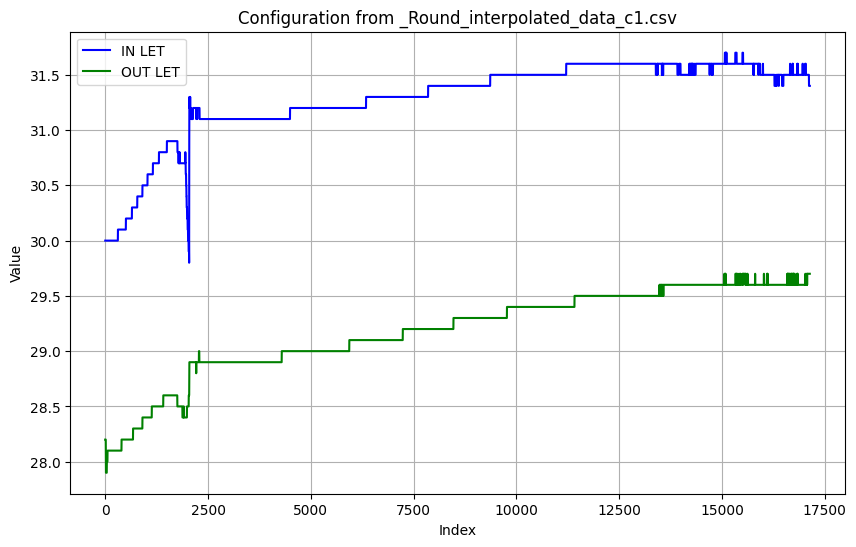

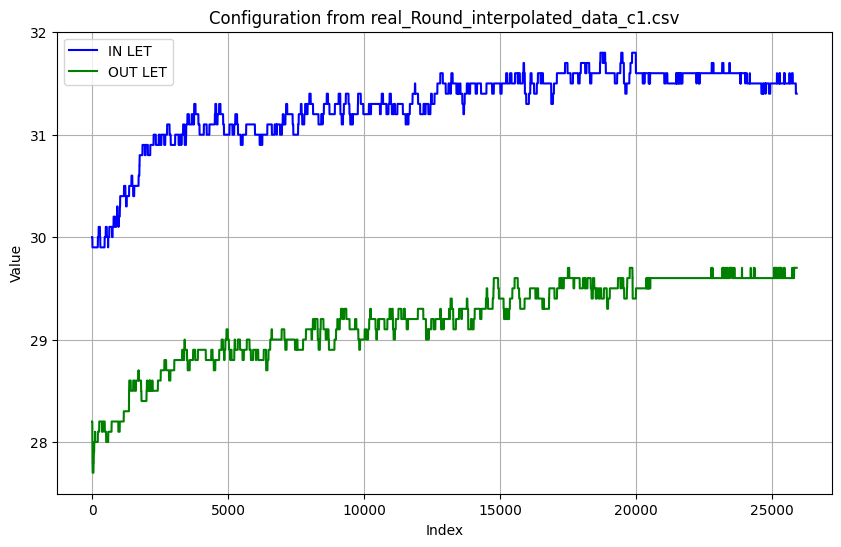

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# List of file paths
file_paths = [
    # '_Round_interpolated_data_c1.csv',
    '_Round_interpolated_data_c1.csv',
    'real_Round_interpolated_data_c1.csv'
    # '03110139_7_11_24_10_54.csv'
    # '03111605_7_12_24_1_0_am.csv'
    # '03110001_7_12_24_2_13.csv'
    # '03111312-7_12_24_4_28.csv'
    # '03111527_7_13_24_6_49_am.csv' # Missing comma added here
    # '03110017_7_14_24_9_14_am.csv' # Missing comma added here
    # '01020553_7_13_24_7_10_pm.csv'   # Missing comma added here
]

# Iterate over each file and plot the data
for file_path in file_paths:
    data = pd.read_csv(file_path)   

    # Ensure all data is numeric and handle missing values
    data = data.apply(pd.to_numeric, errors='coerce')
    data = data.fillna(method='ffill')

    # Extract relevant columns (12, 13, 14) and rows (from 3 to the end)
    data_subset = data.iloc[1:, [0, 1]]

    # Plot columns with different colors, solid lines, and add legend
    plt.figure(figsize=(10, 6))
    plt.plot(data_subset.iloc[:, 0], label='IN LET', color='blue', linestyle='-')
    plt.plot(data_subset.iloc[:, 1], label='OUT LET', color='green', linestyle='-')
    # plt.plot(data_subset.iloc[:, 2], label='Water Bath', color='red', linestyle='-')
    # plt.plot(data_subset.iloc[:, 0] - data_subset.iloc[:, 1] + 25, label='Water Bath Offset', color='black', linestyle='-')

    plt.title(f'Configuration from {file_path}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    # Show the plot for each file
plt.show()
